# S&P 500 Fairness and Explainability Analysis

This notebook explores fairness and explainability in predictive modeling using S&P 500 stock data. It covers feature engineering, model training, SHAP explainability, fairness mitigation, and group-wise performance evaluation.

In [4]:
# === 1. Imports and Utility Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate
import os, hashlib, json, mlflow
from datetime import datetime

def file_hash(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        h.update(f.read())
    return h.hexdigest()


In [5]:
# === 2. Helper Functions ===
import pathlib

def ensure_dir(path):
    pathlib.Path(path).parent.mkdir(parents=True, exist_ok=True)

def log_group_metrics(prefix, group_col, y_true, y_pred, idx_df):
    rows = []
    y_pred_series = pd.Series(y_pred, index=y_true.index)
    for label in idx_df[group_col].dropna().unique():
        idx = idx_df.index[idx_df[group_col] == label]
        if len(idx) == 0:
            continue
        yt = y_true.loc[idx]
        yp = y_pred_series.loc[idx]
        row = {
            "group": f"{group_col}={label}",
            "accuracy": accuracy_score(yt, yp),
            "precision": precision_score(yt, yp, zero_division=0),
            "recall": recall_score(yt, yp, zero_division=0),
            "selection_rate": (yp == 1).mean(),
        }
        rows.append(row)
        mlflow.log_metrics({
            f"{prefix}_acc__{group_col}={label}": row["accuracy"],
            f"{prefix}_prec__{group_col}={label}": row["precision"],
            f"{prefix}_rec__{group_col}={label}": row["recall"],
            f"{prefix}_sel__{group_col}={label}": row["selection_rate"],
        })
    return pd.DataFrame(rows)
def log_overall_metrics(prefix, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    sel = (y_pred == 1).mean()
    mlflow.log_metrics({
        f"{prefix}_accuracy": acc,
        f"{prefix}_precision": prec,
        f"{prefix}_recall": rec,
        f"{prefix}_selection_rate": sel,
    })
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "selection_rate": sel,
    }

In [8]:
# === REPAIR & ENSURE: target + groups exist (run this before the split) ===
import pandas as pd
import numpy as np

def _pick(colnames, *cands):
    for c in cands:
        if c in colnames:
            return c
    raise KeyError(f"None of {cands} found in columns: {list(colnames)}")

# 0) If df isn't loaded, load it here (comment this out if you already have df)
DATA_PATH = "sp500_clean.csv"  # set if needed
df = pd.read_csv(DATA_PATH)

# 1) Standardize core columns (handles capitalization variants)
cols = set(df.columns)
date_col  = _pick(cols, "date", "Date", "DATE")
open_col  = _pick(cols, "open", "Open", "OPEN")
high_col  = _pick(cols, "high", "High", "HIGH")
low_col   = _pick(cols, "low", "Low", "LOW")
close_col = _pick(cols, "close", "Close", "CLOSE")
vol_col   = _pick(cols, "volume", "Volume", "VOLUME")

if {"open","high","low","close","volume","date"}.issubset(cols) is False:
    df = df.rename(columns={
        date_col:"date", open_col:"open", high_col:"high",
        low_col:"low", close_col:"close", vol_col:"volume"
    })

# 2) Sort by date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date").reset_index(drop=True)

# 3) Create target if missing
if "next_day_up" not in df.columns:
    df["next_close"] = df["close"].shift(-1)
    df["next_day_up"] = (df["next_close"] > df["close"]).astype(int)
    df = df.dropna(subset=["next_close"]).reset_index(drop=True)

# 4) Create groups if missing
if "volatility" not in df.columns:
    df["volatility"] = (df["high"] - df["low"]).abs()
if "group_volatility" not in df.columns:
    df["group_volatility"] = pd.qcut(
        df["volatility"].rank(method="first"), 3, labels=["low","med","high"]
    )
if "group_volume" not in df.columns:
    df["group_volume"] = pd.qcut(
        df["volume"].rank(method="first"), 3, labels=["low","med","high"]
    )

# 5) Quick sanity peek (optional)
print("Now have columns:", [c for c in ["date","open","high","low","close","volume","next_day_up","group_volatility","group_volume"] if c in df.columns])
print(df[["date","close","next_day_up"]].tail())
print("Group counts (volatility):\n", df["group_volatility"].value_counts())
print("Group counts (volume):\n", df["group_volume"].value_counts())

Now have columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'next_day_up', 'group_volatility', 'group_volume']
           date        close  next_day_up
1252 2024-12-23  5974.069824            1
1253 2024-12-24  6040.040039            0
1254 2024-12-26  6037.589844            0
1255 2024-12-27  5970.839844            0
1256 2024-12-30  5906.939941            0
Group counts (volatility):
 group_volatility
low     419
med     419
high    419
Name: count, dtype: int64
Group counts (volume):
 group_volume
low     419
med     419
high    419
Name: count, dtype: int64


In [26]:
import numpy as np
import pandas as pd

def dataset_summary(
    df,
    target_col,
    group_col,
    date_col="date",
    train_idx=None,
    test_idx=None,
    train_frac=0.8,
):
    """
    Prints a labeled summary of train/test slices:
      - sizes
      - date ranges
      - positive class rate
      - group distribution
    Returns (sizes_tbl, groups_tbl, train_idx, test_idx).
    """
    # --- ensure indices ---
    if train_idx is None or test_idx is None:
        N = len(df)
        split = int(train_frac * N)
        train_idx = np.arange(split)
        test_idx  = np.arange(split, N)
        print(f"[info] computed indices → train={len(train_idx)}, test={len(test_idx)}")

    # --- sizes ---
    train_size = len(train_idx); test_size = len(test_idx)

    # --- date ranges ---
    tr_dates = df.iloc[train_idx][date_col]
    te_dates = df.iloc[test_idx][date_col]
    tr_range = f"{pd.to_datetime(tr_dates).min().date()} → {pd.to_datetime(tr_dates).max().date()}"
    te_range = f"{pd.to_datetime(te_dates).min().date()} → {pd.to_datetime(te_dates).max().date()}"

    # --- label balance (positive rate) ---
    tr_pos = df.iloc[train_idx][target_col].mean()
    te_pos = df.iloc[test_idx][target_col].mean()

    # --- group distribution ---
    tr_g = df.iloc[train_idx][group_col].value_counts().sort_index()
    te_g = df.iloc[test_idx][group_col].value_counts().sort_index()
    # replace these lines inside dataset_summary:


    # --- tables ---
    sizes_tbl = pd.DataFrame({
        "set": ["train","test"],
        "rows": [train_size, test_size],
        "date_range": [tr_range, te_range],
        f"pos_rate({target_col}=1)": [round(tr_pos,3), round(te_pos,3)]
    })

    groups_tbl = (
        pd.DataFrame({
            "group": tr_g.index.tolist() + te_g.index.tolist(),
            "count": tr_g.values.tolist() + te_g.values.tolist(),
            "set":   ["train"]*len(tr_g) + ["test"]*len(te_g)
        })
        .pivot(index="group", columns="set", values="count")
        .fillna(0).astype(int)
    )

    # --- pretty print ---
    print("=== DATASET SUMMARY ===")
    print(sizes_tbl.to_string(index=False))
    print(f"\nGroup distribution by set ({group_col}):")
    print(groups_tbl)
    print("\nIndex continuity check:",
          f"last train idx={max(train_idx)} | first test idx={min(test_idx)}")

    return sizes_tbl, groups_tbl, train_idx, test_idx
sizes_tbl, groups_tbl, train_idx, test_idx = dataset_summary(
    df=df,
    train_idx=train_idx,
    test_idx=test_idx,
    target_col=TARGET,
    group_col=SENSITIVE_GROUP_COL,
    date_col="date"
)
print(
    "Index ranges:",
    f"train {train_idx.min()}–{train_idx.max()} (n={len(train_idx)})  |  "
    f"test {test_idx.min()}–{test_idx.max()} (n={len(test_idx)})"
)


=== DATASET SUMMARY ===
  set  rows              date_range  pos_rate(next_day_up=1)
train  1005 2020-01-02 → 2023-12-28                    0.529
 test   252 2023-12-29 → 2024-12-30                    0.567

Group distribution by set (group_volume):
set    test  train
group             
high     31    388
low     141    278
med      80    339

Index continuity check: last train idx=1004 | first test idx=1005
Index ranges: train 0–1004 (n=1005)  |  test 1005–1256 (n=252)


In [27]:
# === 4. Baseline model: train & evaluate ===
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, brier_score_loss

model = LGBMClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=5, num_leaves=31,
    subsample=0.9, colsample_bytree=0.9, random_state=42
)
model.fit(X_train, y_train)

# predictions
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("Baseline accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Baseline precision:", round(precision_score(y_test, y_pred, zero_division=0), 4))
print("Baseline recall   :", round(recall_score(y_test, y_pred, zero_division=0), 4))
print("Baseline Brier    :", round(brier_score_loss(y_test, y_prob), 4))


[LightGBM] [Info] Number of positive: 532, number of negative: 473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1005, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529353 -> initscore=0.117548
[LightGBM] [Info] Start training from score 0.117548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [28]:
# === 5. Fairness mitigation (Demographic Parity) ===
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

constraint = DemographicParity()
mitigator = ExponentiatedGradient(estimator=model, constraints=constraint)

# use the EXACT train indices for sensitive features
sensitive_train = df.iloc[train_idx][SENSITIVE_GROUP_COL].astype(str).reset_index(drop=True)

mitigator.fit(
    X_train, y_train,
    sensitive_features=sensitive_train
)

y_pred_fair = mitigator.predict(X_test).astype(int)

print("Fairness-mitigated accuracy :", round(accuracy_score(y_test, y_pred_fair), 4))
print("Fairness-mitigated precision:", round(precision_score(y_test, y_pred_fair, zero_division=0), 4))
print("Fairness-mitigated recall   :", round(recall_score(y_test, y_pred_fair, zero_division=0), 4))


[LightGBM] [Info] Number of positive: 532, number of negative: 473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1005, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529353 -> initscore=0.117548
[LightGBM] [Info] Start training from score 0.117548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

=== Demographic Parity (DP) Gap Summary ===
Baseline DP gap : 0.4610  (46.1%)
Fair DP gap     : 0.4171  (41.7%)
Change          : ↓ 0.0438  (9.5% relative change)

=== Per-Group Selection Rates & Accuracy ===
group sel_rate_base sel_rate_fair accuracy_base accuracy_fair dev_from_mean_base dev_from_mean_fair
 high          0.0%          3.2%         35.5%         38.7%             -36.2%             -32.4%
  low         82.3%         77.3%         53.9%         53.2%              46.1%              41.7%
  med         26.2%         26.2%         51.2%         51.2%              -9.9%              -9.3%


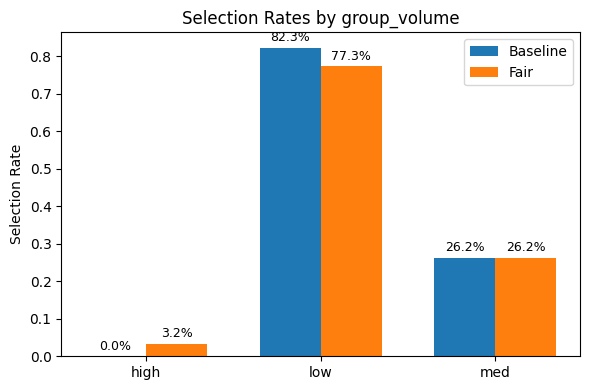

In [33]:
# === Clear DP gap report (readable + % + deltas) ===
import pandas as pd
import numpy as np

# Tidy tables
base_tbl = mf_base.by_group.rename(columns={"sel_rate":"sel_rate_base","accuracy":"accuracy_base"})
fair_tbl = mf_fair.by_group.rename(columns={"sel_rate":"sel_rate_fair","accuracy":"accuracy_fair"})
report = base_tbl.join(fair_tbl)

# Means & deviations from mean (DP uses selection-rate parity)
mu_base = report["sel_rate_base"].mean()
mu_fair = report["sel_rate_fair"].mean()
report["dev_from_mean_base"] = report["sel_rate_base"] - mu_base
report["dev_from_mean_fair"] = report["sel_rate_fair"] - mu_fair

# DP gaps
dp_gap_base = report["dev_from_mean_base"].abs().max()
dp_gap_fair = report["dev_from_mean_fair"].abs().max()
dp_abs_change = dp_gap_fair - dp_gap_base
dp_rel_change = (dp_abs_change / dp_gap_base) if dp_gap_base != 0 else np.nan

# Nicely formatted printout
print("=== Demographic Parity (DP) Gap Summary ===")
print(f"Baseline DP gap : {dp_gap_base:.4f}  ({dp_gap_base*100:.1f}%)")
print(f"Fair DP gap     : {dp_gap_fair:.4f}  ({dp_gap_fair*100:.1f}%)")

sign = "↓" if dp_abs_change < 0 else ("↑" if dp_abs_change > 0 else "→")
rel_pct = f"{abs(dp_rel_change)*100:.1f}%" if not np.isnan(dp_rel_change) else "n/a"
print(f"Change          : {sign} {abs(dp_abs_change):.4f}  ({rel_pct} relative change)")

# Compact table (percentages, rounded)
display_cols = [
    "sel_rate_base","sel_rate_fair","accuracy_base","accuracy_fair",
    "dev_from_mean_base","dev_from_mean_fair"
]
view = report[display_cols].copy()
to_pct = ["sel_rate_base","sel_rate_fair","dev_from_mean_base","dev_from_mean_fair"]
for c in to_pct:
    view[c] = (view[c] * 100).round(1).astype(str) + "%"

view["accuracy_base"] = (report["accuracy_base"]*100).round(1).astype(str) + "%"
view["accuracy_fair"] = (report["accuracy_fair"]*100).round(1).astype(str) + "%"

print("\n=== Per-Group Selection Rates & Accuracy ===")
print(view.rename_axis("group").reset_index().to_string(index=False))

# === Visual: selection rates by group (baseline vs fair) ===
import matplotlib.pyplot as plt
import numpy as np

# After report = base_tbl.join(fair_tbl)
plot_df = report.reset_index()
# Rename the first column to "group" if it's not already
if plot_df.columns[0] != "group":
    plot_df = plot_df.rename(columns={plot_df.columns[0]: "group"})

x = np.arange(len(plot_df["group"]))
w = 0.35

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - w/2, plot_df["sel_rate_base"], width=w, label="Baseline")
ax.bar(x + w/2, plot_df["sel_rate_fair"], width=w, label="Fair")
ax.set_xticks(x)
ax.set_xticklabels(plot_df["group"])
ax.set_ylabel("Selection Rate")
ax.set_title(f"Selection Rates by {SENSITIVE_GROUP_COL}")
ax.legend()
for i, (b, f) in enumerate(zip(plot_df["sel_rate_base"], plot_df["sel_rate_fair"])):
    ax.text(i - w/2, b + 0.01, f"{b*100:.1f}%", ha="center", va="bottom", fontsize=9)
    ax.text(i + w/2, f + 0.01, f"{f*100:.1f}%", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig("selection_rates_by_group.png", dpi=200)
plt.show()


In [40]:
# show plots inside the notebook AND save them
%matplotlib inline
import matplotlib.pyplot as plt

def show_and_save(fig, path, dpi=200):
    fig.tight_layout()
    fig.savefig(path, dpi=dpi)
    plt.show(fig)   # display inline


c:\Users\DELL\Documents\GitHub\XAI Project\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


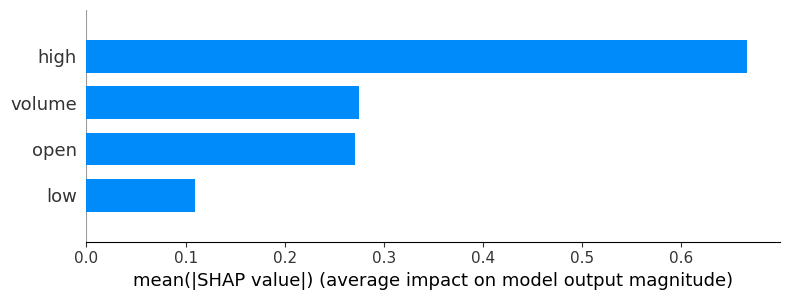

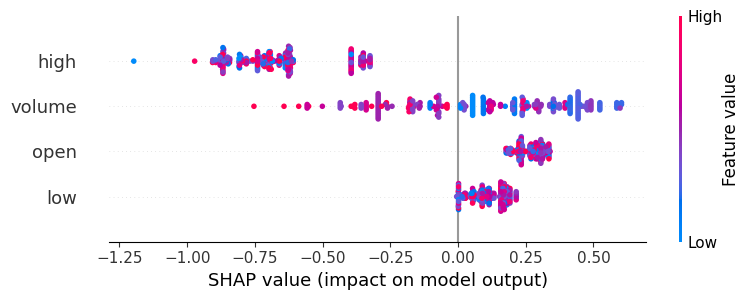

In [41]:
import shap

explainer = shap.TreeExplainer(model)
sv = explainer.shap_values(X_test)
sv = sv[1] if isinstance(sv, list) else sv  # binary case

# bar
fig = plt.figure()
shap.summary_plot(sv, X_test, feature_names=X_test.columns, plot_type="bar", show=False)
show_and_save(plt.gcf(), "shap_summary_bar.png")

# beeswarm
fig = plt.figure()
shap.summary_plot(sv, X_test, feature_names=X_test.columns, show=False)
show_and_save(plt.gcf(), "shap_beeswarm.png")


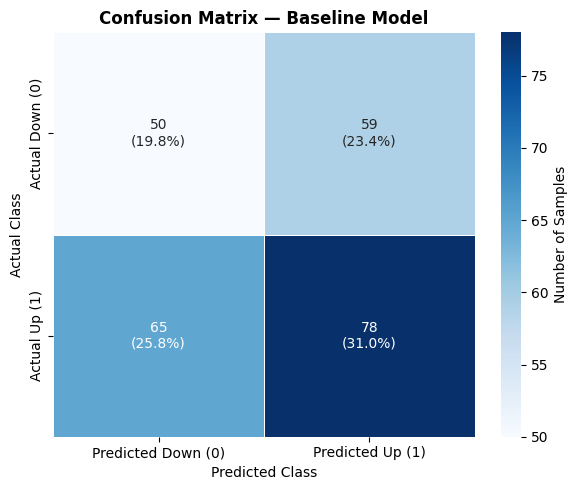

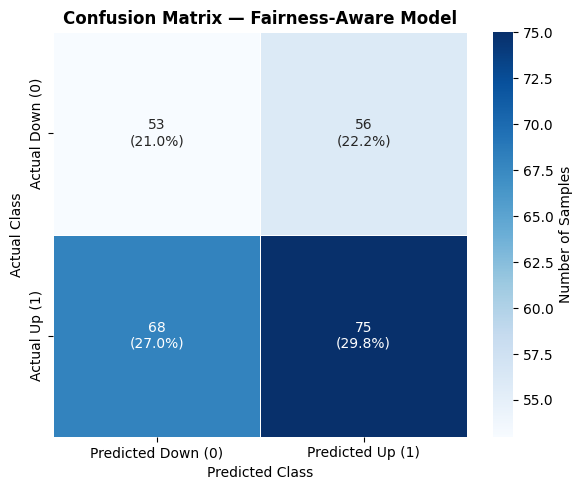

In [42]:
# --- Confusion Matrix: readable labels + counts + percentages (self-contained) ---
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(y_true, y_hat, title, path, labels=("Down (0)", "Up (1)")):
    # compute matrix & percentages
    cm = confusion_matrix(y_true, y_hat)
    cm_sum = cm.sum()
    cm_perc = (cm / cm_sum) * 100.0

    # dataframe with nice row/col labels
    cm_df = pd.DataFrame(
        cm,
        index=[f"Actual {labels[0]}", f"Actual {labels[1]}"],
        columns=[f"Predicted {labels[0]}", f"Predicted {labels[1]}"]
    )

    # annotation strings: "count\n(percent%)"
    annot = np.array([[f"{cm[i,j]}\n({cm_perc[i,j]:.1f}%)" for j in range(2)] for i in range(2)])

    # plot
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(
        cm_df, annot=annot, fmt="", cmap="Blues",
        cbar_kws={"label": "Number of Samples"},
        linewidths=0.5, linecolor="white", ax=ax
    )
    ax.set_title(title, fontsize=12, weight="bold")
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("Actual Class")
    plt.tight_layout()

    # save AND display (no external helpers)
    fig.savefig(path, dpi=200)
    plt.show()

# === Generate both confusion matrices ===
plot_cm(y_test, y_pred,
        "Confusion Matrix — Baseline Model",
        "cm_baseline.png")

plot_cm(y_test, y_pred_fair,
        "Confusion Matrix — Fairness-Aware Model",
        "cm_fair.png")

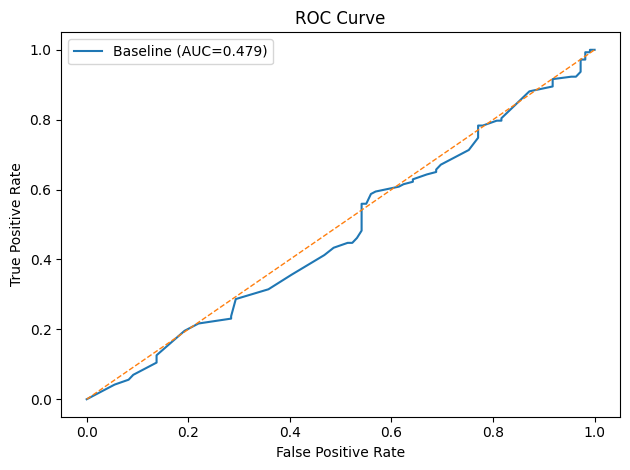

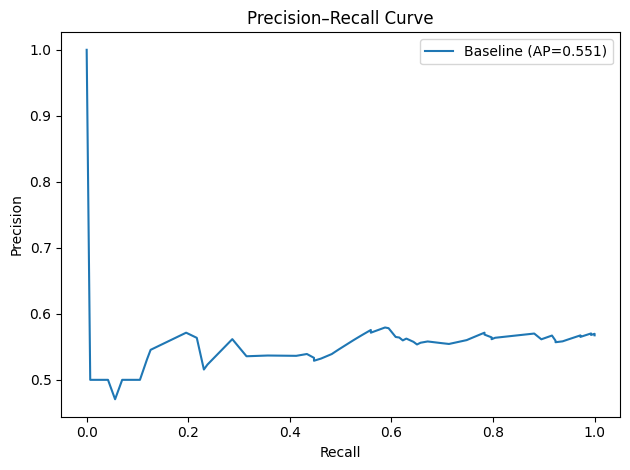

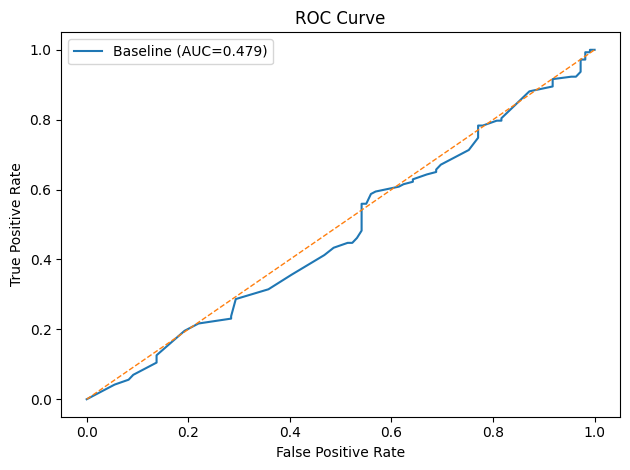

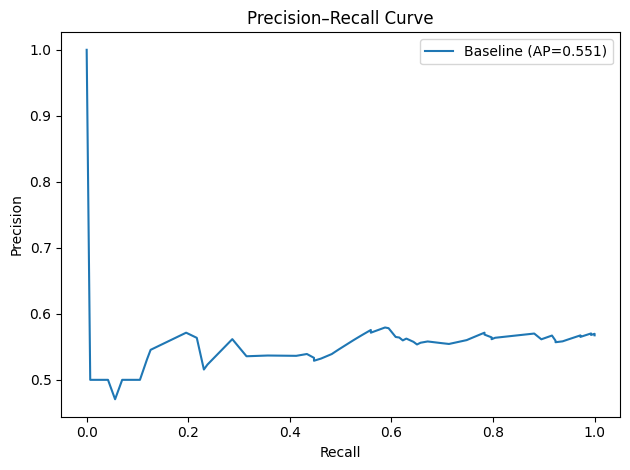

In [39]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# for 'fair' curve, we need probabilities; ExponentiatedGradient returns class labels.
# as a proxy, plot ROC/PR for the baseline model only (standard); keep fair as a point.
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

# ROC
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"Baseline (AUC={roc_auc:.3f})")
ax.plot([0,1],[0,1],'--', lw=1)
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend()
show_and_save(fig, "roc_baseline.png")

# PR
fig, ax = plt.subplots()
ax.plot(rec, prec, label=f"Baseline (AP={ap:.3f})")
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curve")
ax.legend()
show_and_save(fig, "pr_baseline.png")
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# for 'fair' curve, we need probabilities; ExponentiatedGradient returns class labels.
# as a proxy, plot ROC/PR for the baseline model only (standard); keep fair as a point.
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

# ROC
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"Baseline (AUC={roc_auc:.3f})")
ax.plot([0,1],[0,1],'--', lw=1)
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend()
show_and_save(fig, "roc_baseline.png")

# PR
fig, ax = plt.subplots()
ax.plot(rec, prec, label=f"Baseline (AP={ap:.3f})")
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curve")
ax.legend()
show_and_save(fig, "pr_baseline.png")


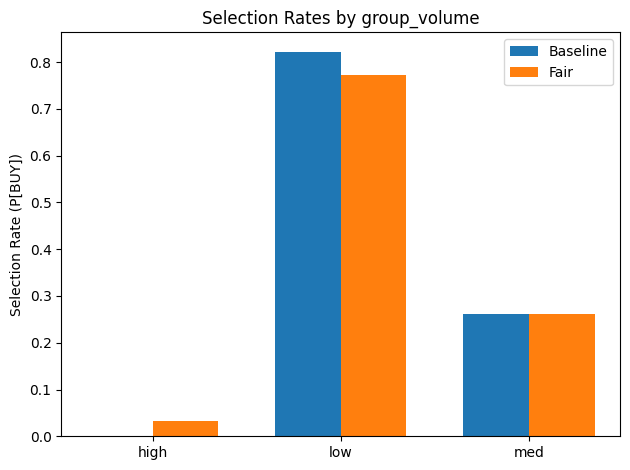

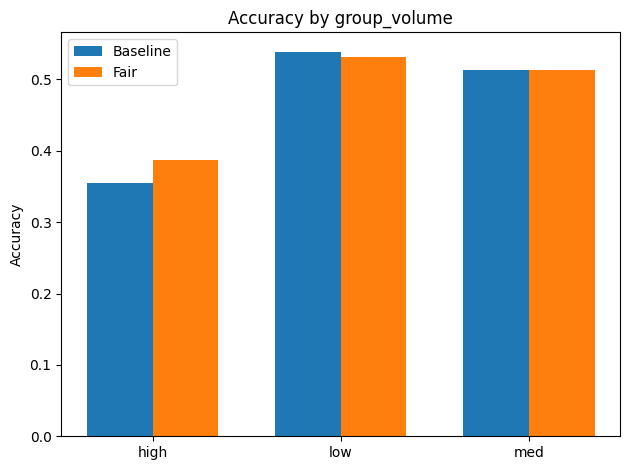

In [34]:

#Build tidy table from MetricFrame outputs
base_tbl = mf_base.by_group.reset_index()
fair_tbl = mf_fair.by_group.reset_index()

# normalize whatever the index column is called to "group"
base_idx_name = mf_base.by_group.index.name or "index"
fair_idx_name = mf_fair.by_group.index.name or "index"
if base_idx_name != "group":
    base_tbl = base_tbl.rename(columns={base_idx_name: "group"})
if fair_idx_name != "group":
    fair_tbl = fair_tbl.rename(columns={fair_idx_name: "group"})

plot_df = base_tbl[["group","sel_rate","accuracy"]].merge(
    fair_tbl[["group","sel_rate","accuracy"]],
    on="group", suffixes=("_base","_fair")
)

# selection-rate bars
x = np.arange(len(plot_df["group"]))
w = 0.35
fig, ax = plt.subplots()
ax.bar(x - w/2, plot_df["sel_rate_base"], width=w, label="Baseline")
ax.bar(x + w/2, plot_df["sel_rate_fair"], width=w, label="Fair")
ax.set_xticks(x); ax.set_xticklabels(plot_df["group"])
ax.set_ylabel("Selection Rate (P[BUY])")
ax.set_title(f"Selection Rates by {SENSITIVE_GROUP_COL}")
ax.legend()
show_and_save(fig, "selection_rates_by_group.png")

# accuracy bars
fig, ax = plt.subplots()
ax.bar(x - w/2, plot_df["accuracy_base"], width=w, label="Baseline")
ax.bar(x + w/2, plot_df["accuracy_fair"], width=w, label="Fair")
# ...existing code...
ax.set_xticks(x); ax.set_xticklabels(plot_df["group"])
ax.set_ylabel("Accuracy")
ax.set_title(f"Accuracy by {SENSITIVE_GROUP_COL}")
ax.legend()
show_and_save(fig, "accuracy_by_group.png")


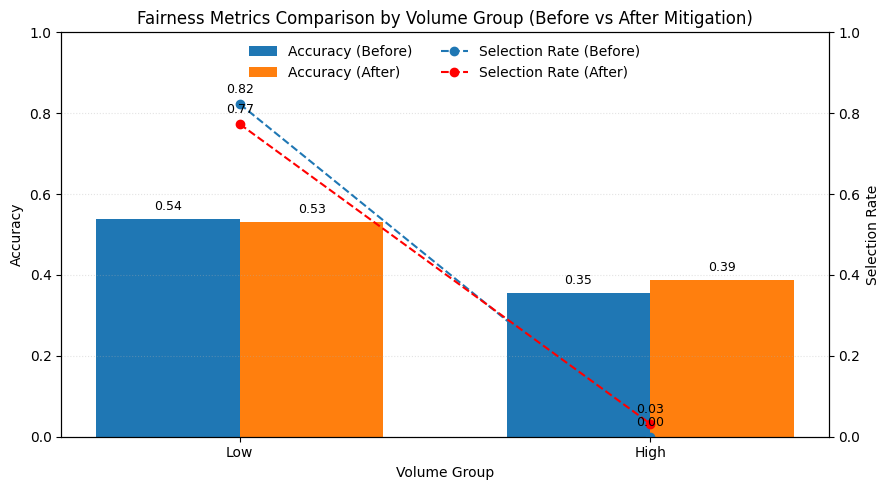

In [38]:
# -# === Figure 4: Accuracy (bars) + Selection Rate (lines), Before vs After ===
import numpy as np
import matplotlib.pyplot as plt
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

# 1) Compute MetricFrames
mf_before = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=df.loc[X_test.index, "group_volume"].astype(str)
).by_group.copy()

mf_after = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=df.loc[X_test.index, "group_volume"].astype(str)
).by_group.copy()

# 2) Order groups consistently
order = ["low", "medium", "high"]
mf_before = mf_before.reindex([g for g in order if g in mf_before.index])
mf_after  = mf_after.reindex([g for g in order if g in mf_after.index])
groups = [g.capitalize() for g in mf_before.index]
x = np.arange(len(groups))
w = 0.35

# 3) Build the plot
fig, ax1 = plt.subplots(figsize=(9, 5))

# Bars: Accuracy (left=before, right=after)
b1 = ax1.bar(x - w/2, mf_before["accuracy"].values, width=w, label="Accuracy (Before)")
b2 = ax1.bar(x + w/2, mf_after["accuracy"].values,  width=w, label="Accuracy (After)")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Volume Group")
ax1.set_xticks(x)
ax1.set_xticklabels(groups)
ax1.set_ylim(0, 1.0)
ax1.grid(axis="y", linestyle=":", alpha=0.35)

# 4) Twin axis for Selection Rate (lines)
ax2 = ax1.twinx()
ax2.plot(x, mf_before["selection_rate"].values, "o--", label="Selection Rate (Before)")
ax2.plot(x, mf_after["selection_rate"].values,  "o--", label="Selection Rate (After)", color="red")
ax2.set_ylabel("Selection Rate")
ax2.set_ylim(0, 1.0)

# 5) Legends (merge both axes)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper center", ncol=2, frameon=False)

plt.title("Fairness Metrics Comparison by Volume Group (Before vs After Mitigation)")
plt.tight_layout()
# plt.savefig("figure4_fairness_before_after.png", dpi=300)
# plt.show()

# 6) (Optional) value labels on bars and points
def add_bar_labels(bars, ax):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.015, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

def add_point_labels(ax, xs, ys):
    for xi, yi in zip(xs, ys):
        ax.text(xi, yi + 0.02, f"{yi:.2f}", ha="center", va="bottom", fontsize=9)

add_bar_labels(b1, ax1)
add_bar_labels(b2, ax1)
add_point_labels(ax2, x, mf_before["selection_rate"].values)
add_point_labels(ax2, x, mf_after["selection_rate"].values)


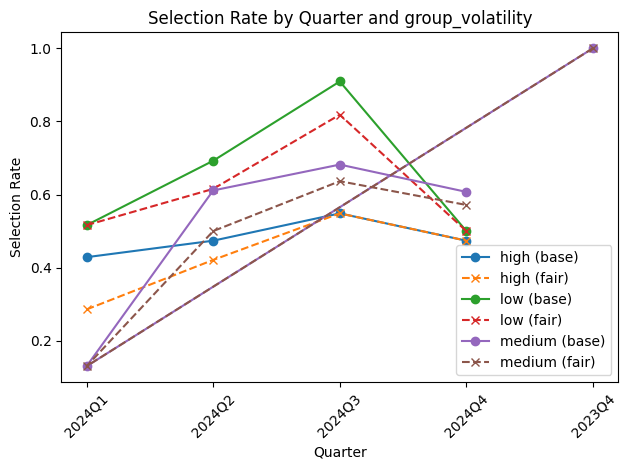

In [72]:
# needs a 'date' column in the test slice
test_dates = df.iloc[test_idx]["date"].reset_index(drop=True)
test_groups = pd.Series(sensitive_test).reset_index(drop=True)
test_df = pd.DataFrame({
    "date": test_dates,
    "group": test_groups,
    "y_pred_base": y_pred,
    "y_pred_fair": y_pred_fair
})

# quarterly label
test_df["quarter"] = test_df["date"].dt.to_period("Q").astype(str)

def agg_sr(tbl, pred_col):
    return tbl.groupby(["quarter","group"])[pred_col].mean().reset_index()

sr_base = agg_sr(test_df, "y_pred_base")
sr_fair = agg_sr(test_df, "y_pred_fair")

# plot: baseline vs fair, one line per group
fig, ax = plt.subplots()
for g in sorted(sr_base["group"].unique()):
    ax.plot(sr_base[sr_base["group"]==g]["quarter"],
            sr_base[sr_base["group"]==g]["y_pred_base"],
            marker="o", label=f"{g} (base)")
    ax.plot(sr_fair[sr_fair["group"]==g]["quarter"],
            sr_fair[sr_fair["group"]==g]["y_pred_fair"],
            marker="x", linestyle="--", label=f"{g} (fair)")
ax.set_xlabel("Quarter"); ax.set_ylabel("Selection Rate")
ax.set_title(f"Selection Rate by Quarter and {SENSITIVE_GROUP_COL}")
ax.legend()
plt.xticks(rotation=45)
show_and_save(fig, "selection_rate_stability_over_time.png")


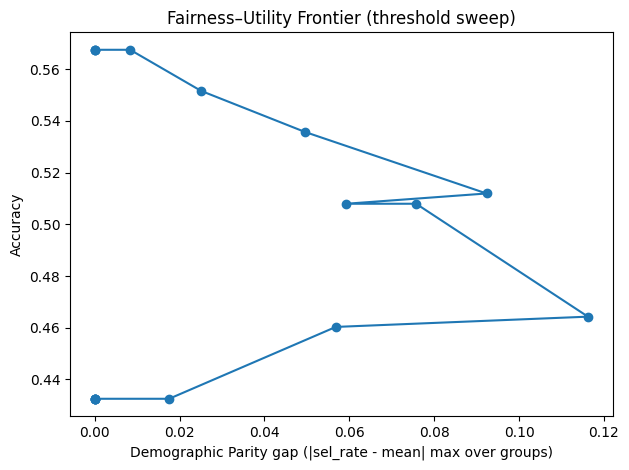

In [73]:
# sweep thresholds on baseline probs and compute accuracy and DP gap
thr = np.linspace(0.1, 0.9, 17)
accs, gaps = [], []
for t in thr:
    yp = (y_prob >= t).astype(int)
    mf = MetricFrame(
        metrics={"sel_rate": selection_rate, "accuracy": accuracy_score},
        y_true=y_test, y_pred=yp,
        sensitive_features=sensitive_test
    )
    accs.append(mf.overall["accuracy"])
    g = (mf.by_group["sel_rate"] - mf.by_group["sel_rate"].mean()).abs().max()
    gaps.append(float(g))

fig, ax = plt.subplots()
ax.plot(gaps, accs, marker="o")
ax.set_xlabel("Demographic Parity gap (|sel_rate - mean| max over groups)")
ax.set_ylabel("Accuracy")
ax.set_title("Fairness–Utility Frontier (threshold sweep)")
show_and_save(fig, "fairness_utility_frontier.png")


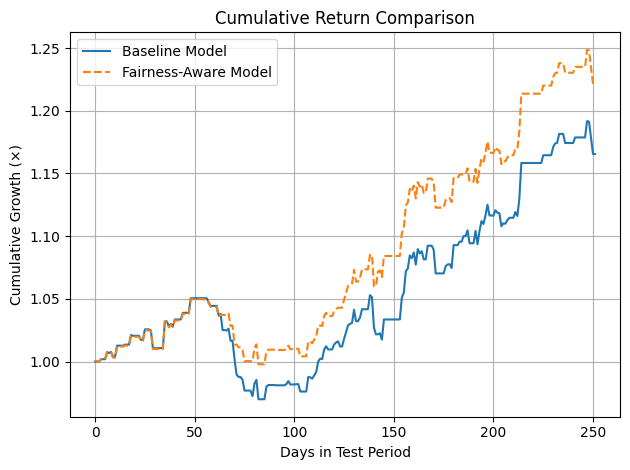

In [75]:
# === Simple Cumulative Return Comparison ===
import numpy as np
import matplotlib.pyplot as plt

# daily % change in closing price for the test window
close_test = df.iloc[test_idx]["close"].values
daily_return = np.diff(close_test) / close_test[:-1]
daily_return = np.append(daily_return, 0)  # pad to match length

# baseline and fair signals (1=buy, 0=sell/hold)
signal_base = y_pred
signal_fair = y_pred_fair

# strategy: only earn the next-day return when signal == 1
equity_base = (1 + signal_base * daily_return).cumprod()
equity_fair = (1 + signal_fair * daily_return).cumprod()

# normalise both to start at 1
equity_base /= equity_base[0]
equity_fair /= equity_fair[0]

plt.figure()
plt.plot(equity_base, label="Baseline Model")
plt.plot(equity_fair, label="Fairness-Aware Model", linestyle="--")
plt.title("Cumulative Return Comparison")
plt.xlabel("Days in Test Period")
plt.ylabel("Cumulative Growth (×)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cumulative_return_comparison.png", dpi=200)
plt.show()

In [55]:
# === 8. MLflow logging (optional) ===
import json, mlflow
from datetime import datetime
import pathlib

def ensure_dir(path):
    pathlib.Path(path).parent.mkdir(parents=True, exist_ok=True)

mlflow.set_experiment("sp500_fair_xai")

with mlflow.start_run(run_name=f"lgbm_dp_{datetime.utcnow().isoformat()}"):
    # lineage/params
    if 'DATA_PATH' in globals():
        mlflow.log_param("data_path", DATA_PATH)
    mlflow.log_param("features", json.dumps(FEATURES))
    mlflow.log_param("target", "next_day_up")
    mlflow.log_param("sensitive_feature", SENSITIVE_GROUP_COL)
    mlflow.log_params({
        "model":"LGBMClassifier",
        "n_estimators":300, "lr":0.05, "max_depth":5, "num_leaves":31,
        "subsample":0.9, "colsample_bytree":0.9, "seed":42,
        "fairness_constraint":"DemographicParity"
    })

    # metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, brier_score_loss
    mlflow.log_metrics({
        "acc_base": accuracy_score(y_test, y_pred),
        "prec_base": precision_score(y_test, y_pred, zero_division=0),
        "rec_base":  recall_score(y_test, y_pred, zero_division=0),
        "brier_base": brier_score_loss(y_test, y_prob),
        "acc_fair":  accuracy_score(y_test, y_pred_fair),
        "prec_fair": precision_score(y_test, y_pred_fair, zero_division=0),
        "rec_fair":  recall_score(y_test, y_pred_fair, zero_division=0),
        "dp_gap_base": float(dp_gap_base),
        "dp_gap_fair": float(dp_gap_fair),
    })

    # artifacts: fairness tables
    base_tbl = mf_base.by_group.reset_index().rename(columns={"index": SENSITIVE_GROUP_COL})
    fair_tbl = mf_fair.by_group.reset_index().rename(columns={"index": SENSITIVE_GROUP_COL})
    ensure_dir("artifacts/base_group_metrics.csv")
    ensure_dir("artifacts/fair_group_metrics.csv")
    base_tbl.to_csv("artifacts/base_group_metrics.csv", index=False)
    fair_tbl.to_csv("artifacts/fair_group_metrics.csv", index=False)
    mlflow.log_artifact("artifacts/base_group_metrics.csv")
    mlflow.log_artifact("artifacts/fair_group_metrics.csv")

    # artifacts: plots
    ensure_dir("artifacts/shap_summary_bar.png")
    ensure_dir("artifacts/calibration_baseline.png")
    if os.path.exists("shap_summary_bar.png"):
        os.replace("shap_summary_bar.png", "artifacts/shap_summary_bar.png")
    if os.path.exists("calibration_baseline.png"):
        os.replace("calibration_baseline.png", "artifacts/calibration_baseline.png")
    mlflow.log_artifact("artifacts/shap_summary_bar.png")
    mlflow.log_artifact("artifacts/calibration_baseline.png")

print("MLflow run logged.")

2025/10/16 23:06:48 INFO mlflow.tracking.fluent: Experiment with name 'sp500_fair_xai' does not exist. Creating a new experiment.
C:\Users\DELL\AppData\Local\Temp\ipykernel_19712\2855714982.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  with mlflow.start_run(run_name=f"lgbm_dp_{datetime.utcnow().isoformat()}"):


MLflow run logged.


In [44]:
# 1) Columns present?
print({"has_next_day_up": "next_day_up" in df.columns,
       "has_group_volatility": "group_volatility" in df.columns,
       "has_features": all(c in df.columns for c in ["open","high","low","volume"])})

# 2) Any NaNs in features/label on the test set?
print("NaNs in X_test:", X_test.isna().sum().sum(), " | NaNs in y_test:", y_test.isna().sum())

# 3) Class balance (train/test) — just to see if label looks reasonable
print("y_train value counts:\n", y_train.value_counts(normalize=True).round(3))
print("y_test  value counts:\n", y_test.value_counts(normalize=True).round(3))

# 4) Group distribution in train/test (your sensitive feature)
print("group (train):\n", idx_df_train["group_volatility"].value_counts())
print("group (test):\n",  idx_df_test["group_volatility"].value_counts())

# 5) No leakage: confirm test dates come strictly after train dates
print("Last train idx:", y_train.index.max(), " | First test idx:", y_test.index.min())


{'has_next_day_up': False, 'has_group_volatility': True, 'has_features': True}
NaNs in X_test: 0  | NaNs in y_test: 0
y_train value counts:
 target
1    0.529
0    0.471
Name: proportion, dtype: float64
y_test  value counts:
 target
1    0.567
0    0.433
Name: proportion, dtype: float64
group (train):
 group_volatility
high    342
low     335
med     328
Name: count, dtype: int64
group (test):
 group_volatility
med     91
low     84
high    77
Name: count, dtype: int64
Last train idx: 1005  | First test idx: 1006


# Baseline model: train & evaluate

In [28]:
# === 4. Baseline model: train & evaluate ===
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, brier_score_loss

model = LGBMClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=5, num_leaves=31,
    subsample=0.9, colsample_bytree=0.9, random_state=42
)
model.fit(X_train, y_train)

# predictions
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("Baseline accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Baseline precision:", round(precision_score(y_test, y_pred, zero_division=0), 4))
print("Baseline recall   :", round(recall_score(y_test, y_pred, zero_division=0), 4))
print("Baseline Brier    :", round(brier_score_loss(y_test, y_prob), 4))


[LightGBM] [Info] Number of positive: 532, number of negative: 474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528827 -> initscore=0.115436
[LightGBM] [Info] Start training from score 0.115436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

## Data Preparation and Feature Engineering

This section loads the S&P 500 dataset, performs feature engineering, and creates groupings for volume, volatility, and price change to support fairness and explainability analysis.

In [29]:
# Load dataset
df = pd.read_csv("sp500_clean.csv", parse_dates=["date"])

# Feature Engineering
df["volatility"] = df["high"] - df["low"]
df["price_change"] = df["close"] - df["open"]
df["group_volume"] = pd.qcut(df["volume"], q=3, labels=["low", "medium", "high"])
df["group_volatility"] = pd.qcut(df["volatility"], q=3, labels=["low", "medium", "high"])
df["group_price_change"] = pd.qcut(df["price_change"], q=3, labels=["low", "medium", "high"])

# Binary Target
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)
df.dropna(inplace=True)

In [30]:
# Feature Matrix and Target
features = ["open", "high", "low", "volume"]
X = df[features]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [31]:
# Train Base Model
model = LGBMClassifier(max_depth=5, num_leaves=31, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[LightGBM] [Info] Number of positive: 532, number of negative: 474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528827 -> initscore=0.115436
[LightGBM] [Info] Start training from score 0.115436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\Users\DELL\Documents\GitHub\XAI Project\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\DELL\Documents\GitHub\XAI Project\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


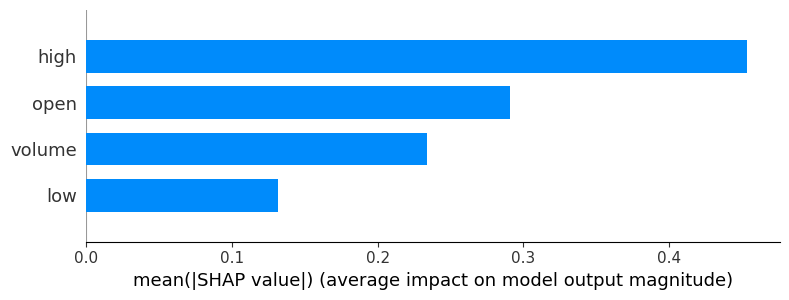

In [32]:
# SHAP Explainability
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_test)[1] if isinstance(explainer.shap_values(X_test), list) else explainer.shap_values(X_test)
shap.summary_plot(shap_vals, X_test, feature_names=features, plot_type="bar")

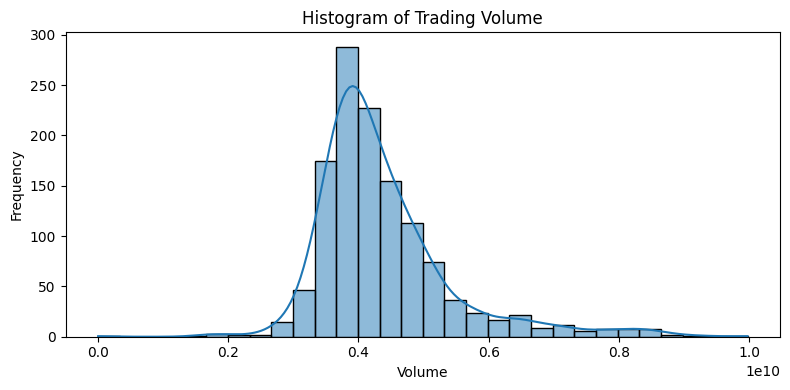

In [61]:
# Histogram of Volume
plt.figure(figsize=(8, 4))
sns.histplot(df["volume"], bins=30, kde=True)
plt.title("Histogram of Trading Volume")
plt.xlabel("Volume")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

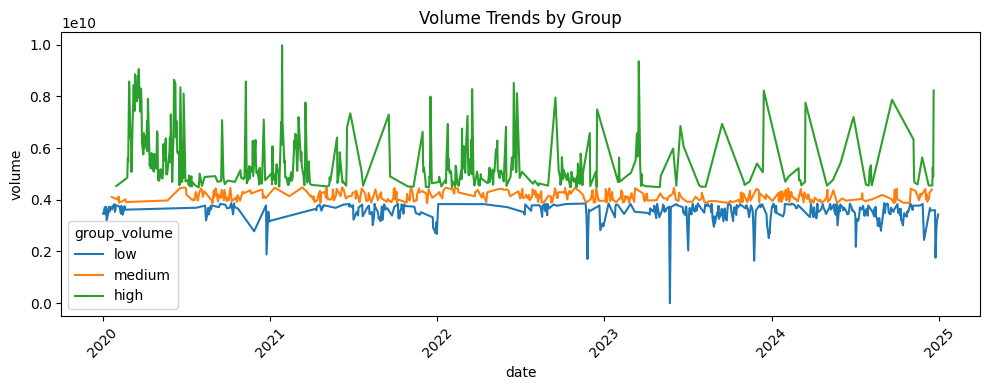

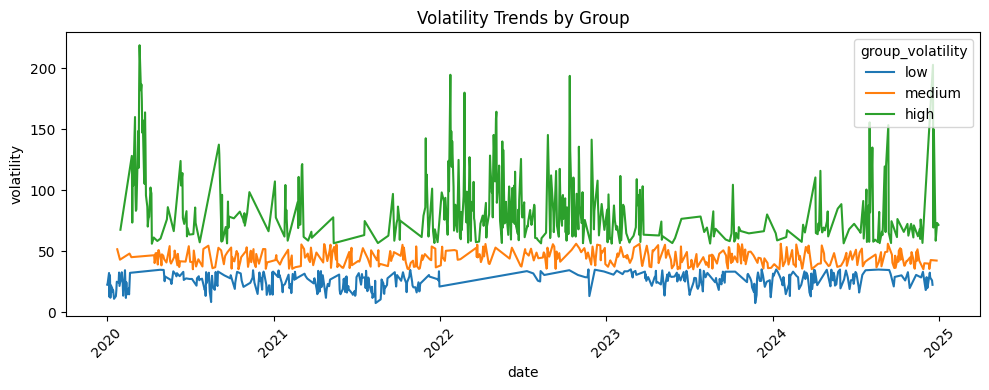

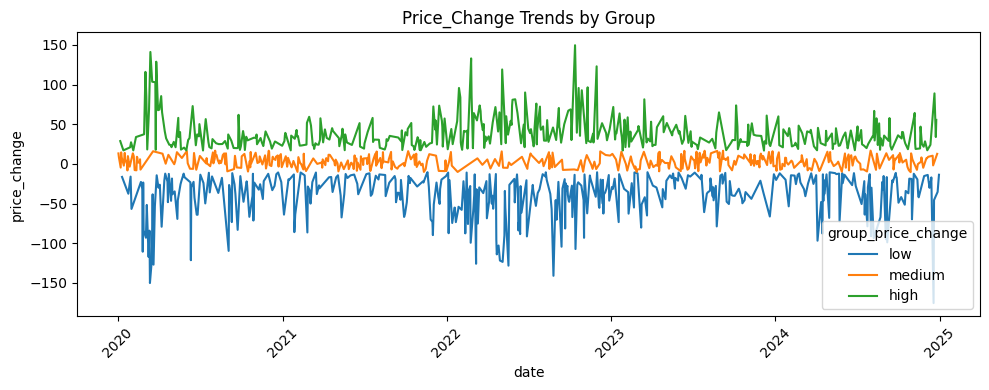

In [60]:
# Time Trends for Volume, Volatility, and Price Change
for col, group in zip(["volume", "volatility", "price_change"],
                      ["group_volume", "group_volatility", "group_price_change"]):
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=df, x="date", y=col, hue=group)
    plt.title(f"{col.title()} Trends by Group")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [59]:
# Group-wise Performance Function
def group_metrics(group_col):
    idx_df = df.iloc[X_test.index]
    for label in idx_df[group_col].dropna().unique():
        group_idx = idx_df[idx_df[group_col] == label].index
        if not group_idx.empty:
            y_true_group = y_test.loc[group_idx]
            y_pred_group = pd.Series(y_pred, index=y_test.index).loc[group_idx]
            acc = accuracy_score(y_true_group, y_pred_group)
            prec = precision_score(y_true_group, y_pred_group, zero_division=0)
            rec = recall_score(y_true_group, y_pred_group, zero_division=0)
            print(f"\n📊 {group_col} = {label}")
            print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

print("\n==== Group Performance by Volume ====")
group_metrics("group_volume")


==== Group Performance by Volume ====

📊 group_volume = low
Accuracy: 0.561, Precision: 0.641, Recall: 0.694

📊 group_volume = medium
Accuracy: 0.474, Precision: 0.433, Recall: 0.500

📊 group_volume = high
Accuracy: 0.500, Precision: 0.588, Recall: 0.494


In [36]:
# Fairness Mitigation with Fairlearn
constraint = DemographicParity()
mitigator = ExponentiatedGradient(
    estimator=LGBMClassifier(max_depth=5, num_leaves=31),
    constraints=constraint
)
mitigator.fit(X_train, y_train, sensitive_features=df.loc[X_train.index, "group_volume"].astype(str))
y_pred_fair = mitigator.predict(X_test)

[LightGBM] [Info] Number of positive: 532, number of negative: 474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528827 -> initscore=0.115436
[LightGBM] [Info] Start training from score 0.115436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [58]:
# Fairness MetricFrame Report
metric_frame = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=df.loc[X_test.index, "group_volume"].astype(str)
)

print("\n🎯 Fairness Metrics (Post-Mitigation):")
print(metric_frame.by_group)


🎯 Fairness Metrics (Post-Mitigation):
              accuracy  selection_rate
group_volume                          
high          0.514493        0.463768
low           0.543860        0.631579
medium        0.543860        0.491228


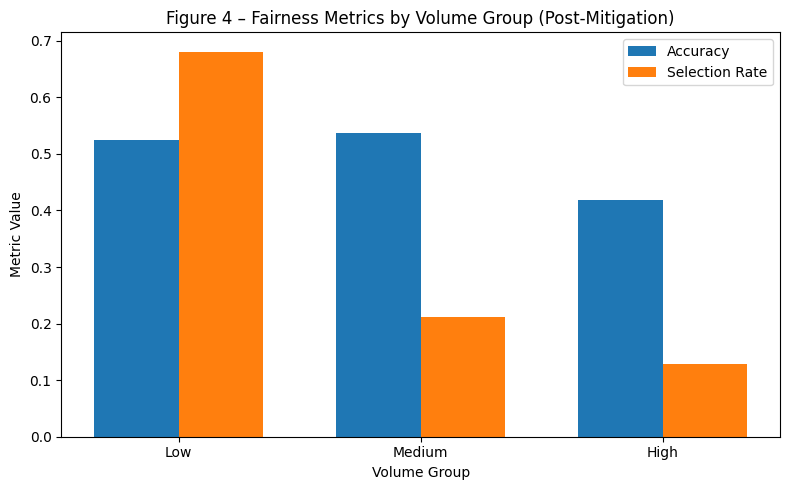

In [57]:
# === FIGURE 4: Fairness Metrics Plot ===
# Optional bar plot of accuracy and selection rate by group
fm = metric_frame.by_group.copy()
fm.index = fm.index.astype(str)

# Optional: enforce order
order = ["low", "medium", "high"]
fm = fm.reindex([g for g in order if g in fm.index])

groups = fm.index.tolist()
x = np.arange(len(groups))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, fm["accuracy"].values, width, label="Accuracy")
plt.bar(x + width/2, fm["selection_rate"].values, width, label="Selection Rate")

plt.xlabel("Volume Group")
plt.ylabel("Metric Value")
plt.title("Figure 4 – Fairness Metrics by Volume Group (Post‑Mitigation)")
plt.xticks(ticks=x, labels=[g.capitalize() for g in groups])
plt.legend()
plt.tight_layout()
plt.show()

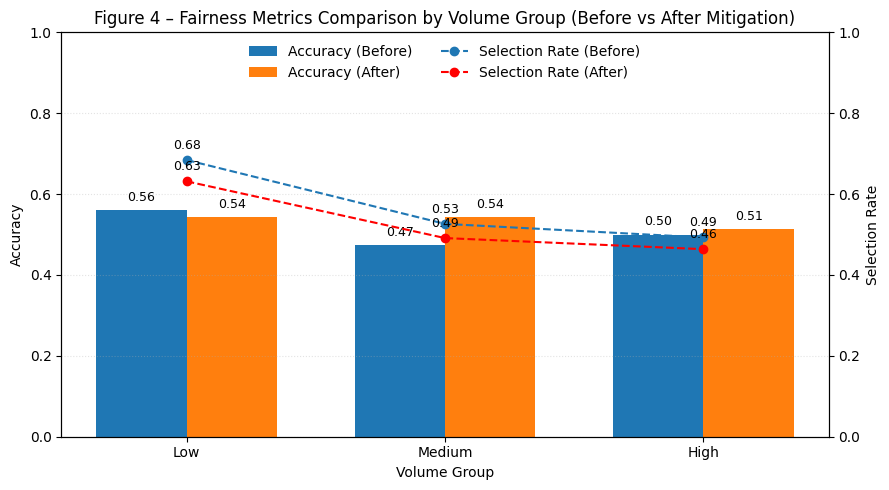

In [56]:
# -# === Figure 4: Accuracy (bars) + Selection Rate (lines), Before vs After ===
import numpy as np
import matplotlib.pyplot as plt
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

# 1) Compute MetricFrames
mf_before = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=df.loc[X_test.index, "group_volume"].astype(str)
).by_group.copy()

mf_after = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=df.loc[X_test.index, "group_volume"].astype(str)
).by_group.copy()

# 2) Order groups consistently
order = ["low", "medium", "high"]
mf_before = mf_before.reindex([g for g in order if g in mf_before.index])
mf_after  = mf_after.reindex([g for g in order if g in mf_after.index])
groups = [g.capitalize() for g in mf_before.index]
x = np.arange(len(groups))
w = 0.35

# 3) Build the plot
fig, ax1 = plt.subplots(figsize=(9, 5))

# Bars: Accuracy (left=before, right=after)
b1 = ax1.bar(x - w/2, mf_before["accuracy"].values, width=w, label="Accuracy (Before)")
b2 = ax1.bar(x + w/2, mf_after["accuracy"].values,  width=w, label="Accuracy (After)")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Volume Group")
ax1.set_xticks(x)
ax1.set_xticklabels(groups)
ax1.set_ylim(0, 1.0)
ax1.grid(axis="y", linestyle=":", alpha=0.35)

# 4) Twin axis for Selection Rate (lines)
ax2 = ax1.twinx()
ax2.plot(x, mf_before["selection_rate"].values, "o--", label="Selection Rate (Before)")
ax2.plot(x, mf_after["selection_rate"].values,  "o--", label="Selection Rate (After)", color="red")
ax2.set_ylabel("Selection Rate")
ax2.set_ylim(0, 1.0)

# 5) Legends (merge both axes)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper center", ncol=2, frameon=False)

plt.title("Figure 4 – Fairness Metrics Comparison by Volume Group (Before vs After Mitigation)")
plt.tight_layout()
# plt.savefig("figure4_fairness_before_after.png", dpi=300)
# plt.show()

# 6) (Optional) value labels on bars and points
def add_bar_labels(bars, ax):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.015, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

def add_point_labels(ax, xs, ys):
    for xi, yi in zip(xs, ys):
        ax.text(xi, yi + 0.02, f"{yi:.2f}", ha="center", va="bottom", fontsize=9)

add_bar_labels(b1, ax1)
add_bar_labels(b2, ax1)
add_point_labels(ax2, x, mf_before["selection_rate"].values)
add_point_labels(ax2, x, mf_after["selection_rate"].values)
